# Zoidberg 2.0

## Introduction

We were given a dataset of x-rays, which took around 20 minutes to install from their server. To speed things up and for convenience we sanitized the dataset and uploaded it to hugging face hub. We will see how fast and concise this solution turned out to be.

We outsourced the following data processing tasks to these files :

- [Finding the right image mask](./src/image_mask.ipynb)
- [Data preprocessing and saving in `.npz` file](./src/image_mask.ipynb)

Our goal with the dataset is to find the right machine learning model to help doctors in detecting pneumonia. We will proceed by pulling the `train` split of the dataset (as you can see with the `split="train"` parameter).


We will begin by loading the **preprocessed** dataset from the file.


In [ ]:
import numpy as np

processed_data = np.load("./datasets/processed_data.npz", allow_pickle=True)

In [ ]:
x_train = processed_data["x_train"]
y_train = processed_data["y_train"]
x_test = processed_data["x_test"]
y_test = processed_data["y_test"]
x_eval = processed_data["x_eval"]
y_eval = processed_data["y_eval"]

In [ ]:
import os

if os.path.exists("./datasets/x_train_pca.npy"):
    x_train_pca = np.load("./datasets/x_train_pca.npy")
    x_test_pca = np.load("./datasets/x_test_pca.npy")
    x_eval_pca = np.load("./datasets/x_eval_pca.npy")

Next, we will calculate the offset from the geometric center of each image in the training set.

### Why Calculate the Offset?

Calculating the offset between the center of mass (COM) and the geometric center of each image is crucial for several reasons:

1. **Alignment and Normalization**:
   - By understanding the offset, we can align the images more accurately. This alignment helps in normalizing the dataset, ensuring that the features of interest (e.g., lungs in x-ray images) are consistently positioned across all images. This consistency is vital for the performance of machine learning models.

2. **Feature Extraction**:
   - The offset can serve as an additional feature for machine learning models. For instance, the displacement of the COM might reveal patterns or anomalies specific to certain conditions, such as pneumonia. Including this feature can enhance the model's ability to distinguish between different classes.

Now let's take a look at how we can proceed with calculating the offset.

### Function: `get_center_of_mass`

This function calculates the center of mass (COM) of a binary image.

- **Purpose**: 
  - To compute the average position of all the foreground pixels in a binary image.

- **Parameters**:
  - `image` (numpy.ndarray): The input binary image represented as a NumPy array.

- **Returns**:
  - `center` (tuple[int, int]): A tuple containing the coordinates (row, column) of the center of mass of the binary image. If the center of mass cannot be computed (e.g., if the image is empty), it returns `(0, 0)`.

- **Steps**:
  1. **Convert to Binary Image**:
     - The input image is converted to a binary image where pixels with values greater than 128 are considered foreground (`True` or `1`), and others are considered background (`False` or `0`).
  2. **Compute Center of Mass**:
     - The `center_of_mass` function from the `scipy.ndimage` module is used to compute the center of mass of the binary image.
  3. **Handle NaN Values**:
     - If the computed center of mass contains any `NaN` values, the function returns `(0, 0)`.
     - Otherwise, it returns the computed center of mass.

- **Example**:
  - If the input image is a binary image with foreground pixels forming a shape, the function will return the average position of those pixels.

In [ ]:
from scipy.ndimage import center_of_mass

def get_center_of_mass(image: np.ndarray) -> tuple[int, int]:
    binary_image = np.array(image) > 128
    com = center_of_mass(binary_image)
    return (0, 0) if np.isnan(com).any() else com

### Function: `calculate_offset`

This function calculates the offset between the center of mass (COM) and the geometric center of a binary image.

- **Purpose**: 
  - To compute the displacement of the center of mass relative to the geometric center of the image.

- **Parameters**:
  - `image` (numpy.ndarray): The input binary image represented as a NumPy array.

- **Returns**:
  - `offset` (numpy.ndarray): A NumPy array representing the offset between the center of mass and the geometric center. The offset has the same dimensionality as the input image.

- **Steps**:
  1. **Compute Center of Mass**:
     - The function `get_center_of_mass` is called to compute the center of mass of the binary image.
  2. **Convert Image to NumPy Array**:
     - The input image is converted to a NumPy array.
  3. **Compute Geometric Center**:
     - The geometric center is computed as the center of the image grid, which is assumed to be at half the width and half the height of the image.
  4. **Calculate Offset**:
     - The offset is calculated as the difference between the geometric center and the center of mass.
  5. **Check for NaN Values**:
     - If any NaN values are found in the offset, an exception is raised.
  6. **Return Offset**:
     - The computed offset is returned.

- **Example**:
  - If the input image is a binary image with a certain shape, the function will return the displacement of the center of mass of that shape relative to the geometric center of the image.

In [ ]:
import math

def calculate_offset(image: np.ndarray) -> np.ndarray:
    com = get_center_of_mass(image)

    image = np.array(image)

    geometric_center = np.array(image.shape) / 2

    offset = geometric_center - com

    # Check for NaN in the tuple
    if any(math.isnan(x) for x in offset):
        raise Exception("nan found")

    return offset

Let's compute the offsets for each image in the training set.

In [ ]:
offsets = [calculate_offset(img) for img in x_train]

### Plotting Offsets of Center of Mass

This following step visualizes the offsets of the center of mass for images in the training set, distinguishing between normal and pneumonia cases.

#### Steps:

1. **Extract Offsets**:
   - `x_offsets` and `y_offsets` are extracted from the `offsets` list, which contains the offsets of the center of mass for each image.
   - These offsets are then separated into `x_offsets_normal`, `x_offsets_pneumonia`, `y_offsets_normal`, and `y_offsets_pneumonia` based on the labels (`y_train`).

2. **Calculate Mean Offsets**:
   - The mean values of `x_offsets` and `y_offsets` are calculated and printed.

3. **Define Extent**:
   - The `extent` variable is defined to set the limits for the image display, assuming the images are 224x224 pixels.

4. **Display Image and Scatter Plot**:
   - A random image from the training set is displayed using `plt.imshow`.
   - Scatter plots of the offsets are overlaid on the image:
     - Blue points represent pneumonia cases.
     - Red points represent normal cases.

This visualization helps in understanding the distribution of the center of mass offsets for normal and pneumonia cases. It can reveal patterns such as whether the center of mass is more centralized in normal cases compared to pneumonia cases.

mean x offset :  -0.8275138212987382
mean y offset :  -20.179250145815896


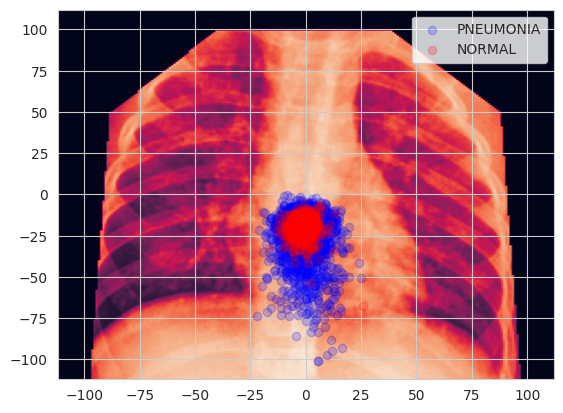

In [45]:
from matplotlib import pyplot as plt
import random

x_offsets = np.array([offset[1] for offset in offsets])
y_offsets = np.array([offset[0] for offset in offsets])
x_offsets_normal = x_offsets[y_train == 0]
x_offsets_pneumonia = x_offsets[y_train == 1]
y_offsets_normal = y_offsets[y_train == 0]
y_offsets_pneumonia = y_offsets[y_train == 1]

print("mean x offset : ", np.mean(x_offsets))
print("mean y offset : ", np.mean(y_offsets))

# Dividing by image sizes
extent = [-224 / 2, 224 / 2, -224 / 2, 224 / 2]

# Display the image with the calculated extents
plt.imshow(x_train[int(random.random() * len(x_train))], extent=extent, aspect="auto")
plt.scatter(
    x_offsets_pneumonia, y_offsets_pneumonia, color="blue", alpha=0.2, label="PNEUMONIA"
)
plt.scatter(x_offsets_normal, y_offsets_normal, color="red", alpha=0.2, label="NORMAL")

plt.legend()
plt.show()

We can observe that on the y-axis, the points are pulled towards the bottom. This can be explained by the presence of the visible **pelvis bone** in some of the images, which results in a downward pull of the **center of mass**.

Additionally, it is interesting to note that the images of `NORMAL` patients exhibit a more grouped and centralized **center of mass** compared to those of patients with `PNEUMONIA`.

## Dimension Reduction

We will first do a **Principal Component Analysis** (`PCA`) to reduce the dimensionality of the images, and then we will plot the first two `PCA`s and then the third in a 3-D plot.

### Why PCA?

#### Overview
Principal Component Analysis (PCA) is a statistical technique used for dimensionality reduction while preserving as much variance as possible in the dataset. In the context of this notebook, PCA is applied to the image data to achieve several key objectives.

#### Reasons for Performing PCA

1. **Dimensionality Reduction**:
   - **High-Dimensional Data**: Image data typically has a high number of dimensions (e.g., a 224x224 image has 50,176 dimensions). High-dimensional data can be computationally expensive to process and analyze.
   - **Reducing Complexity**: PCA reduces the number of dimensions by transforming the data into a new set of orthogonal components (principal components) that capture the most variance in the data. This makes the data more manageable and reduces computational complexity.

2. **Noise Reduction**:
   - **Filtering Noise**: By focusing on the principal components that capture the most variance, PCA helps in filtering out noise and less important features. This can lead to cleaner data and improved performance of machine learning models.

3. **Visualization**:
   - **2D and 3D Plots**: PCA allows for the visualization of high-dimensional data in 2D or 3D plots. This can help in understanding the distribution and relationships within the data.
   - **Pattern Recognition**: Visualizing the principal components can reveal patterns, clusters, and separations between different classes (e.g., `NORMAL` vs. `PNEUMONIA` cases).

### Function: `normalize_images`

This function takes a list of images and processes them by flattening each image into a 1D vector and normalizing the pixel values to be between 0 and 1.

#### Parameters:
- `images` (list or np.ndarray): A list or array of images to be normalized. Each image is expected to be in a format that can be converted to a NumPy array.

#### Returns:
- `np.ndarray`: A NumPy array where each image has been flattened into a 1D vector and its pixel values normalized to the range [0, 1].

In [ ]:
def normalize_images(images: list or np.ndarray) -> np.ndarray:
    return np.array([np.asarray(img).ravel() / 255.0 for img in images])

// TODO : Explain why n_components = 31

Let's first try keeping all components for PCA without limiting `n_components` :

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit_transform(normalize_images(x_train))

### Function: `components_for_variance_percentage`

This function calculates the number of principal components required to achieve a specified percentage of explained variance in a dataset.

#### Parameters:
- `variance_ratios` (`numpy.ndarray`): 
  - An array containing the explained variance ratios for each principal component.
- `per` (float, optional, default=0.99): 
  - The desired percentage of variance to be explained, specified as a float in the range [0, 1].

#### Returns:
- `int`: 
  - The number of principal components needed to explain the specified percentage of variance.

In [ ]:
def components_for_variance_percentage(variance_ratios: np.ndarray, per: float = 0.99):
    cumulative_variance = np.cumsum(variance_ratios)
    return np.argmax(cumulative_variance >= per) + 1

By using a bar plot, we can visualize the number of components needed for each variance percentage : 

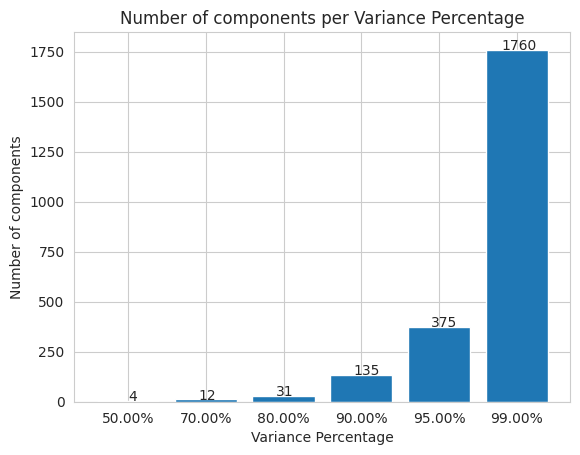

In [42]:
%matplotlib inline

percentages = [0.5, 0.7, 0.8, 0.9, 0.95, 0.99]
num_components = [
    components_for_variance_percentage(pca.explained_variance_ratio_, per)
    for per in percentages
]

fig, ax = plt.subplots()
bars = ax.bar(["{:.2%}".format(value) for value in percentages], num_components)
for bar in bars:
    yval = bar.get_height()
    ax.text(
        (bar.get_x() + (bar.get_width() / 2) - (math.floor(len(str(yval)) / 2) / 10)),
        yval + 0.005,
        yval,
    )

ax.set_title("Number of components per Variance Percentage")
ax.set_xlabel("Variance Percentage")
ax.set_ylabel("Number of components")
plt.show()

Based on the bar plot, we can conclude that 99% of the variance in the data can be explained by `1760` components. We will use this value in the subsequent steps.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1760)

x_train_pca = pca.fit_transform(normalize_images(x_train))

In [ ]:
np.save("./datasets/x_train_pca", x_train_pca)

### Scatter Plot of PCA Components

In this section, we visualize the first two principal components obtained from the PCA transformation of the training data. This scatter plot helps in understanding the distribution and separation of the data points for the two classes: `PNEUMONIA` and `NORMAL`:

- We use `seaborn.scatterplot` to plot the first two principal components for the `PNEUMONIA` cases. The points are colored blue.

- Similarly, we plot the first two principal components for the `NORMAL` cases. The points are colored orange

- We label the x-axis as "PC-1" and the y-axis as "PC-2" to indicate the first and second principal components, respectively.

In [ ]:
%matplotlib inline
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.scatterplot(x=x_train_pca[y_train == 1, 0], y=x_train_pca[y_train == 1, 1], color="blue", label="PNEUMONIA", alpha=0.3)
sns.scatterplot(x=x_train_pca[y_train == 0, 0], y=x_train_pca[y_train == 0, 1], color="orange", label="NORMAL", alpha=0.3)
plt.xlabel("PC-1"), plt.ylabel("PC-2")
plt.show()

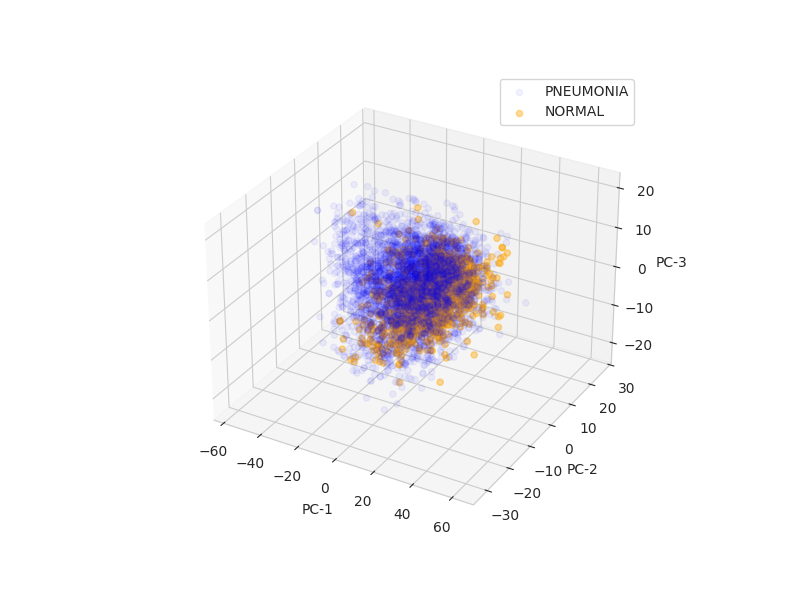

In [46]:
%matplotlib widget

# Assuming X_3d is your 3D data array and labels is your corresponding labels array
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    x_train_pca[y_train == 1, 0],
    x_train_pca[y_train == 1, 1],
    x_train_pca[y_train == 1, 2],
    color="blue",
    label="PNEUMONIA",
    alpha=0.05
)

ax.scatter(
    x_train_pca[y_train == 0, 0],
    x_train_pca[y_train == 0, 1],
    x_train_pca[y_train == 0, 2],
    color="orange",
    label="NORMAL",
    alpha=0.4
)

ax.set_xlabel('PC-1')
ax.set_ylabel('PC-2')
ax.set_zlabel('PC-3')

plt.legend()
plt.show()

In [ ]:
%matplotlib inline 

explained_variance_ratio_10 = pca.explained_variance_ratio_[:10]
pc_10 = [f"PC-{i}" for i in range(1, len(explained_variance_ratio_10) + 1)]

plt.bar(pc_10, explained_variance_ratio_10, color="blue")
plt.title("Explained Variance Ratio by Component")
plt.grid(True)
plt.show()

In [ ]:
np.sum(pca.explained_variance_ratio_)

In [ ]:
x_test_pca = pca.transform(normalize_images(x_test))
x_eval_pca = pca.transform(normalize_images(x_eval))

np.save("./datasets/x_test_pca", x_test_pca)
np.save("./datasets/x_eval_pca", x_eval_pca)

## Model Discovery

We will use `RandomizedSearchCV` with the `roc-auc` scoring to be able to test a wide array of hyperparameters the most efficient way possible. The reason why we use `roc-auc` scoring is that we have class imbalance and accuracy only captures the correct guesses. So if we have a **dummy** model that only guesses the majority class, we will have a score of $\approx63\%$ pretty _decent_ right ? So instead, `roc-auc` calculates the **area under the Receiver Operating Characteristic** curve which basically plots the **true positive rate** (TPR) against the **false positive rate** (FPR) for different threshold values. In other terms it evaluates the ability for a model to differentiate between positive and negative instances across threshold values. We will see an example of how it works for `SVC` and for the rest we'll just use the score.


In addition, for each model, after extracting the best parameters we will `train` and `evaluate` them with the found parameters using **Cross Validation** (with `StratifiedKFold` to preserve percentage of samples of each class) whilst keeping track of `["f1", "accuracy", "roc_auc"]` scores for maximum generalization.


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


def randomized_search_cv(estimator, param_distributions: dict):
    rand_search_cv = RandomizedSearchCV(
        estimator, param_distributions, scoring="recall", cv=cv, random_state=42
    )
    rand_search_cv_results = rand_search_cv.fit(x_train_pca, y_train)
    return rand_search_cv_results

In [ ]:
from sklearn.svm import SVC

svc = SVC()

param_distributions = {
    "C": [0.1, 1, 10, 100, 1000],
    "kernel": ["rbf", "poly", "sigmoid"],
    "degree": list(range(1, 11)),  # Just for "poly"
}

svc_search = randomized_search_cv(svc, param_distributions)
svc_search.best_params_

In [ ]:
import re
import pandas as pd


def plot_cv_results(cv_results_, title=""):
    df = pd.DataFrame(cv_results_)
    df = df.sort_values(by="rank_test_score")

    pattern = re.compile(r"split[0-9]+_test_score")

    split_columns = [c for c in df.columns.values.tolist() if pattern.match(c)]

    # Picking only the columns to plot
    df = df[["params"] + split_columns]
    df["params"] = df["params"].astype(str)

    # Rotating the dataframe
    df = df.melt(id_vars="params", value_vars=split_columns)

    plt.figure(figsize=(10, 6))
    sns.boxplot(df, x="value", y="params", fliersize=0)
    plt.xlabel("ROC_AUC Score")
    plt.title(title)
    plt.show()

In [ ]:
%matplotlib inline

plot_cv_results(svc_search.cv_results_)

In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    recall_score,
)

from src.utils.helpers import plot_confusion_matrix

models_scores = {}


# Evaluating a model from best params
def evaluate_model(model, cv):
    # set the params to be the best combination
    model_name = type(model).__name__
    model.set_params(**cv.best_params_)

    # train the model with the best params combination
    model.fit(x_train_pca, y_train)

    y_pred = model.predict(x_test_pca)

    cm = confusion_matrix(y_test, y_pred)

    models_scores[model_name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
    }

    plot_confusion_matrix(cm, model_name)

In [ ]:
evaluate_model(svc, svc_search)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_distributions = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 100, 1000, None],
    "max_features": ["sqrt", "log2", 0.5],
    "min_samples_leaf": [1, 2, 5, 10],
}

rfc = RandomForestClassifier()

rfc_search = randomized_search_cv(rfc, param_distributions)
rfc_best_params = rfc_search.best_params_

In [ ]:
%matplotlib inline

plot_cv_results(rfc_search.cv_results_)

In [ ]:
evaluate_model(rfc, rfc_search)

In [ ]:
from src.utils.NeuralNetPy import TrainingData2dI

train_data = TrainingData2dI(x_train_pca, y_train)
train_data.batch(128)

In [ ]:
from src.utils.NeuralNetPy import models

network = models.Network()  # simple network

In [ ]:
from src.utils.NeuralNetPy import layers, ACTIVATION, WEIGHT_INIT

features_size = len(x_train_pca[0])

network.addLayer(layers.Dense(features_size))
network.addLayer(layers.Dense(318, ACTIVATION.SIGMOID, WEIGHT_INIT.GLOROT))
network.addLayer(layers.Dense(2, ACTIVATION.SOFTMAX, WEIGHT_INIT.GLOROT))

In [ ]:
from src.utils.NeuralNetPy import optimizers, LOSS

network.setup(optimizer=optimizers.Adam(0.01), loss=LOSS.BCE)

In [ ]:
from src.utils.NeuralNetPy import callbacks

network.train(
    train_data, 50, callbacks=[callbacks.CSVLogger("training.csv")], progBar=False
)

In [ ]:
import pandas as pd

training_logs = pd.read_csv("training.csv")

training_logs.head()

In [ ]:
training_logs = training_logs.drop("Unnamed: 3", axis=1)
training_logs["EPOCH"] = training_logs["EPOCH"].astype("int32")

training_logs.head()

In [ ]:
%matplotlib inline 

epochs = training_logs["EPOCH"].to_numpy()
loss = training_logs["LOSS"].to_numpy()
accuracy = training_logs["ACCURACY"].to_numpy()

fig, ax = plt.subplots()

ax.plot(epochs, loss, color="red", label="loss")
ax.plot(epochs, accuracy, color="blue", label="accuracy")

plt.legend()
plt.show()

In [ ]:
predictions = network.predict(x_test_pca)

In [ ]:
predictions = np.argmax(predictions, axis=1)

In [ ]:
%matplotlib inline 

from src.utils.helpers import plot_confusion_matrix

cm = confusion_matrix(y_test, predictions)

plot_confusion_matrix(cm, "NeuralNet")

In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    recall_score,
)


def fit_evaluate_network(network, model_name="NeuralNet"):
    network.train(train_data, 10)
    y_pred = network.predict(x_test_pca)
    y_pred = np.argmax(predictions, axis=1)
    cm = confusion_matrix(y_train, y_pred)
    plot_confusion_matrix(cm, model_name)
    return {
        "accuracy": accuracy_score(y_train, y_pred),
        "roc_auc": roc_auc_score(y_train, y_pred),
        "recall": recall_score(y_train, y_pred),
    }

In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    recall_score,
)


def fit_evaluate_network(network, model_name="NeuralNet"):
    network.train(train_data, 10)
    y_pred = network.predict(x_test_pca)
    y_pred = np.argmax(predictions, axis=1)
    cm = confusion_matrix(y_train, y_pred)
    plot_confusion_matrix(cm, model_name)
    return {
        "accuracy": accuracy_score(y_train, y_pred),
        "roc_auc": roc_auc_score(y_train, y_pred),
        "recall": recall_score(y_train, y_pred),
    }